# Lateral dispersion in Asgard

Given the bandwidth of the Asgard, dispersion effect fatally occurs and can impact the injection in Bifrost and Hi-5.
In addition, the window of the DM is in MgF2 which presents birefringence and dispersion.

This notebook aims at determine if an atmospheric dispersion compensator is necessary.
If yes, for which instrument and where it should be placed.

## Table of contents
1. Packages and functions
2. Refraction in dry air from J to L band
3. Cumulated refracted angle in dry air then through MgF2 glass under orthogonal incidence
4. Same with a tilt if 7.1 degrees as stated by Gordon in the Tech Report


## 1. Packages and functions

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# Some constants
TDIAM = 1.8 # AT diameter
# TDIAM = 8.2 # UT diameter


In [3]:
# Set functions for this study
def refractive_angle(n, z):
    """
    Return the refractive angle.
    
    :param n: refractive angle, can depend on wavelength
    :type n: float
    :param z: angle from zenith, in rad
    :type z: float
    :return: refractive angle, in radians
    :rtype: float

    """
    return (n**2 - 1) / (2 * n**2) * np.tan(z)
    
def snell_descartes(n1, theta1, n2):
    """
    Calculate refracted angle given refractives index of the materials and incoming angle.
    Work for chromatic index
    
    :param n1: chromatic refractive index of the incoming middle
    :type n1: array
    :param theta1: incoming angle in radians
    :type theta1: array, same size as n1
    :param n2: chromatic refractive index of the incoming middle
    :type n2: array, same size as n1
    :return: chromatic refracted angles, in radian
    :rtype: array, same size as n1

    """
    return np.arcsin(n1[:,None] / n2[:,None] * np.sin(theta1))
    
def refractive_index_mgf2_ordinary(wl0):
    """
    Source: https://refractiveindex.info/?shelf=main&book=MgF2&page=Dodge-o
    Ref: Dodge et al. 1984
    
    :param wl: wavelength, in meter
    :type wl: array
    :return: refractive index
    :rtype: array

    """
    wl = wl0 * 1e6

    dispersion = 0.48755108 * wl**2 / (wl**2 - 0.04338408**2) + 0.39875031 * wl**2 / (wl**2 - 0.09461442**2) + 2.3120353 * wl**2 / (wl**2 - 23.793604**2)
    refractive_index = (1 + dispersion)**0.5
    return refractive_index

def refractive_index_mgf2_extraordinary(wl0):
    """
    Source: https://refractiveindex.info/?shelf=main&book=MgF2&page=Dodge-o
    Ref: Dodge et al. 1984
    
    :param wl: wavelength, in meter
    :type wl: array
    :return: refractive index
    :rtype: array

    """
    wl = wl0 * 1e6

    dispersion = 0.41344023 * wl**2 / (wl**2 - 0.03684262**2) + 0.50497499 * wl**2 / (wl**2 - 0.09076162**2) + 2.4904862 * wl**2 / (wl**2 - 23.771995**2)
    refractive_index = (1 + dispersion)**0.5
    return refractive_index

## 2. Refraction in dry air from J to L band

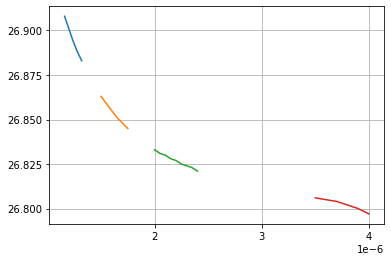

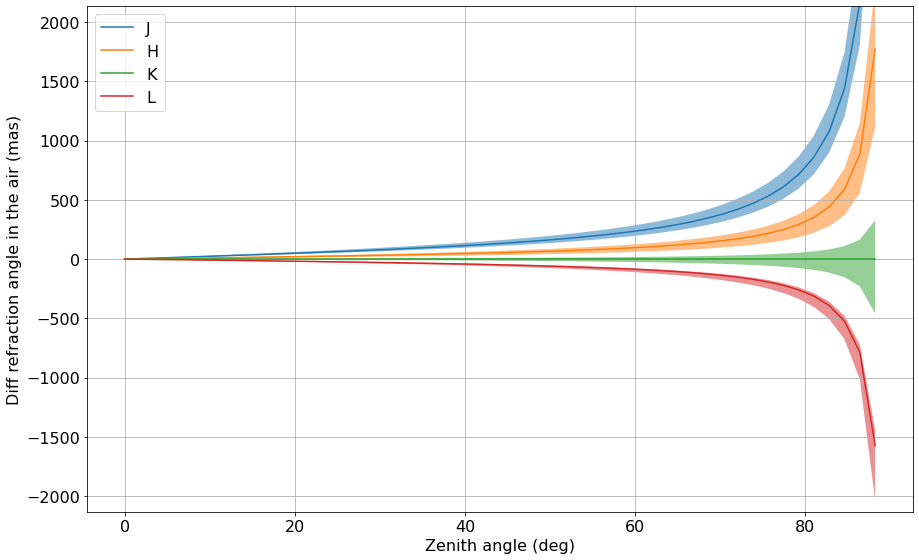

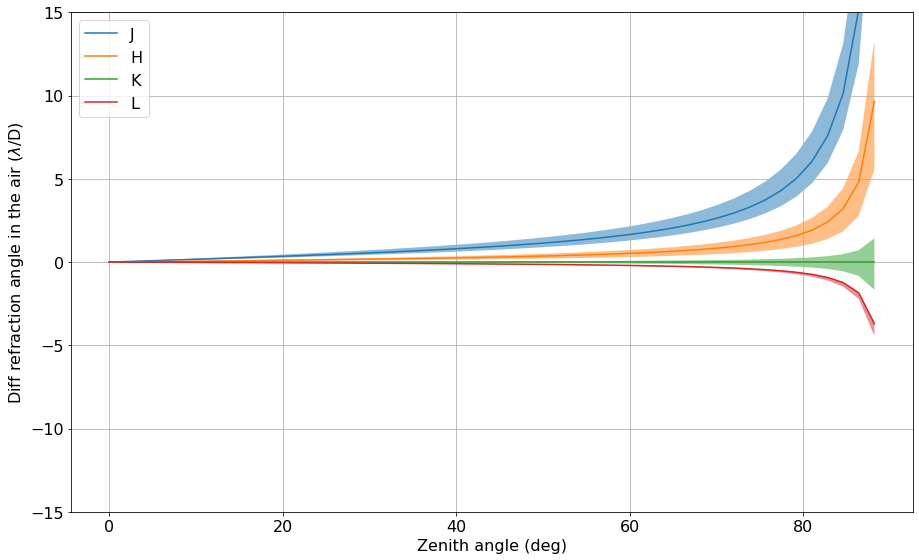

In [4]:
# Define the bands
wlJ = np.array([1.16, 1.2, 1.24, 1.28, 1.32])
wlH = np.array([1.5, 1.55, 1.6, 1.65, 1.7, 1.75])
wlK = np.arange(2., 2.4+0.05, 0.05)
wlL = np.arange(3.5, 4.+0.1, 0.1)

maskJ = [0, 2, -1] # Select edges of the bandwidths
maskH = [0, 2, -1] # Select edges of the bandwidths
maskK = [0, 3, -1] # Select edges of the bandwidths
maskL = [0, 2, -1] # Select edges of the bandwidths
operating_wlK_idx = 3 # Heimdallr operated at 2.18 um

# Concatenate to automate some parts of the script
wl = np.concatenate((wlJ, wlH, wlK, wlL))
idx_mid = np.searchsorted(wl, np.median(wl), sorter=np.argsort(wl)) - 1
wl0_mid = wl[idx_mid]

# Convert in meter
wlJ *= 1e-6
wlH *= 1e-6
wlK *= 1e-6
wlL *= 1e-6

# Size of the PSF
ldJ = wlJ / TDIAM
ldH = wlH / TDIAM
ldK = wlK / TDIAM
ldL = wlL / TDIAM

# Refractive indices of dry hair for the spectral bands
dry_n_J = np.array([26.908, 26.901, 26.894, 26.888, 26.883])
dry_n_H = np.array([26.863, 26.859, 26.855, 26.851, 26.848, 26.845])
dry_n_K = np.array([26.833, 26.831, 26.830, 26.828, 26.827, 26.825, 26.824, 26.823, 26.821])
dry_n_L = np.array([26.806, 26.805, 26.804, 26.802, 26.800, 26.797])

dry_n_J = dry_n_J * 1e-5 + 1
dry_n_H = dry_n_H * 1e-5 + 1
dry_n_K = dry_n_K * 1e-5 + 1
dry_n_L = dry_n_L * 1e-5 + 1

# Check the refractive indices make sense
plt.figure()
plt.plot(wlJ, (dry_n_J-1) * 1e5)
plt.plot(wlH, (dry_n_H-1) * 1e5)
plt.plot(wlK, (dry_n_K-1) * 1e5)
plt.plot(wlL, (dry_n_L-1) * 1e5)
plt.grid()

# Define a range of zenithal angle and the corresponding refracted angle
zenithal_angle = np.linspace(0, np.pi/2, endpoint=False)
theta_J = np.array([refractive_angle(elt, zenithal_angle) for elt in dry_n_J])
theta_H = np.array([refractive_angle(elt, zenithal_angle) for elt in dry_n_H])
theta_K = np.array([refractive_angle(elt, zenithal_angle) for elt in dry_n_K])
theta_L = np.array([refractive_angle(elt, zenithal_angle) for elt in dry_n_L])
metis = refractive_angle(dry_n_L, np.radians(60.))

# Set the angles relatively to the angle of the operating wavelength of Asgard
dtheta_J = theta_J - theta_K[operating_wlK_idx]
dtheta_H = theta_H - theta_K[operating_wlK_idx]
dtheta_K = theta_K - theta_K[operating_wlK_idx]
dtheta_L = theta_L - theta_K[operating_wlK_idx]

# Plot the refracted angles for the bands vs zenital angle in mas
width = 6.528*2
height = width / 1.618
sz = 16
figsz = 5
plt.figure(figsize=(width, height))
plt.rc('xtick', labelsize=sz)
plt.rc('ytick', labelsize=sz)
plt.rc('axes', labelsize=sz)
plt.rc('legend', fontsize=sz)
plt.rc('font', size=sz)
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_J[maskJ[1]].T)*3.6e6, label='J')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_H[maskH[1]].T)*3.6e6, label='H')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_K[maskK[1]].T)*3.6e6, label='K')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_L[maskL[1]].T)*3.6e6, label='L')
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_J[maskJ[0]].T)*3.6e6, np.degrees(dtheta_J[maskJ[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_H[maskH[0]].T)*3.6e6, np.degrees(dtheta_H[maskH[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_K[maskK[0]].T)*3.6e6, np.degrees(dtheta_K[maskK[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_L[maskL[0]].T)*3.6e6, np.degrees(dtheta_L[maskL[2]].T)*3.6e6, alpha=0.5)
plt.grid()
plt.ylim(-15*np.degrees(ldJ[maskJ[1]])*3.6e6, np.degrees(15*ldJ[maskJ[1]])*3.6e6)
plt.xlabel('Zenith angle (deg)')
plt.ylabel('Diff refraction angle in the air (mas)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('dry_air_diff_refraction_angle_mas.png', dpi=150)

# Plot the refracted angles for the bands vs zenital angle in lambda/Tdiam
width = 6.528*2
height = width / 1.618
sz = 16
plt.figure(figsize=(width, height))
plt.rc('xtick', labelsize=sz)
plt.rc('ytick', labelsize=sz)
plt.rc('axes', labelsize=sz)
plt.rc('legend', fontsize=sz)
plt.rc('font', size=sz)
plt.plot(np.degrees(zenithal_angle), dtheta_J[maskJ[1]].T/ldJ[maskJ[1]], label='J')
plt.plot(np.degrees(zenithal_angle), dtheta_H[maskH[1]].T/ldH[maskH[1]], label='H')
plt.plot(np.degrees(zenithal_angle), dtheta_K[maskK[1]].T/ldK[maskK[1]], label='K')
plt.plot(np.degrees(zenithal_angle), dtheta_L[maskL[1]].T/ldL[maskL[1]], label='L')
plt.fill_between(np.degrees(zenithal_angle), dtheta_J[maskJ[0]].T/ldJ[maskJ[0]], dtheta_J[maskJ[2]].T/ldJ[maskJ[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_H[maskH[0]].T/ldH[maskH[0]], dtheta_H[maskH[2]].T/ldH[maskH[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_K[maskK[0]].T/ldK[maskK[0]], dtheta_K[maskK[2]].T/ldK[maskK[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_L[maskL[0]].T/ldL[maskL[0]], dtheta_L[maskL[2]].T/ldL[maskL[2]], alpha=0.5)
plt.grid()
plt.ylim(-15, 15)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Diff refraction angle in the air ($\lambda$/D)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('dry_air_diff_refraction_angle_ld.png', dpi=150)

Clearly, there is some serious dispersion from J to L band

## 3. Cumulated refracted angle in dry air then through MgF2 glass under orthogonal incidence

### 3.1 Interface air-glass

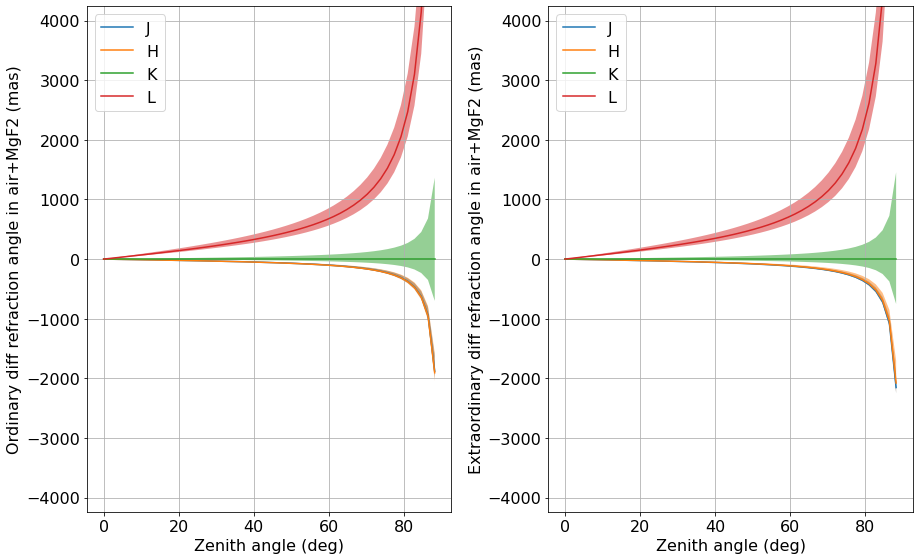

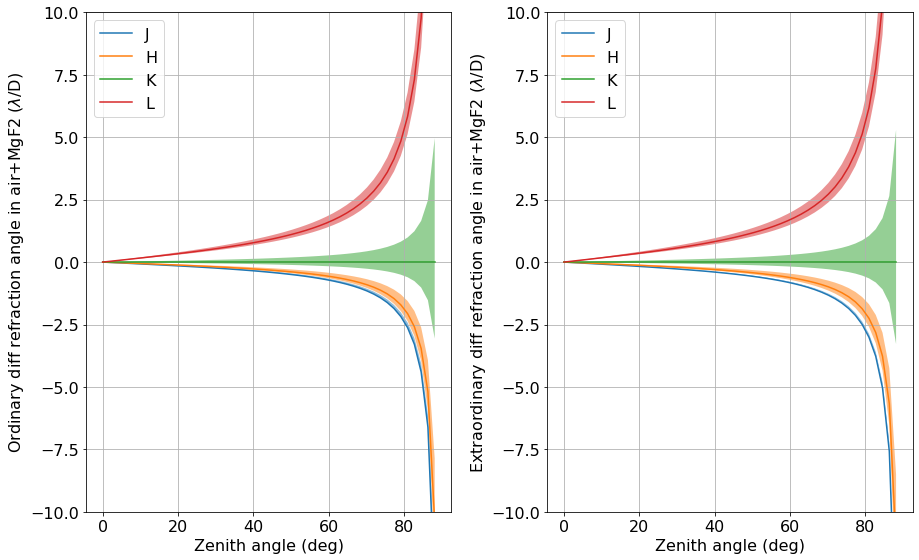

In [9]:
# Same as previously, we define the ordinary and extraordinary refractive indices
# then we calculate the refracted angle inside the MgF2 glass,
window_offset = np.radians(7.1) * 0

mgf2_no_J = refractive_index_mgf2_ordinary(wlJ)
mgf2_ne_J = refractive_index_mgf2_extraordinary(wlJ)
theta_mgf2_no_J = snell_descartes(dry_n_J, theta_J + window_offset, mgf2_no_J)
theta_mgf2_ne_J = snell_descartes(dry_n_J, theta_J + window_offset, mgf2_ne_J) 

mgf2_no_H = refractive_index_mgf2_ordinary(wlH)
mgf2_ne_H = refractive_index_mgf2_extraordinary(wlH)
theta_mgf2_no_H = snell_descartes(dry_n_H, theta_H + window_offset, mgf2_no_H)
theta_mgf2_ne_H = snell_descartes(dry_n_H, theta_H + window_offset, mgf2_ne_H)

mgf2_no_K = refractive_index_mgf2_ordinary(wlK)
mgf2_ne_K = refractive_index_mgf2_extraordinary(wlK)
theta_mgf2_no_K = snell_descartes(dry_n_K, theta_K + window_offset, mgf2_no_K)
theta_mgf2_ne_K = snell_descartes(dry_n_K, theta_K + window_offset, mgf2_ne_K) 

mgf2_no_L = refractive_index_mgf2_ordinary(wlL)
mgf2_ne_L = refractive_index_mgf2_extraordinary(wlL)
theta_mgf2_no_L = snell_descartes(dry_n_L, theta_L + window_offset, mgf2_no_L)
theta_mgf2_ne_L = snell_descartes(dry_n_L, theta_L + window_offset, mgf2_ne_L)

dtheta_mgf2_no_J = theta_mgf2_no_J - theta_mgf2_no_K[operating_wlK_idx]
dtheta_mgf2_no_H = theta_mgf2_no_H - theta_mgf2_no_K[operating_wlK_idx]
dtheta_mgf2_no_K = theta_mgf2_no_K - theta_mgf2_no_K[operating_wlK_idx]
dtheta_mgf2_no_L = theta_mgf2_no_L - theta_mgf2_no_K[operating_wlK_idx]

dtheta_mgf2_ne_J = theta_mgf2_ne_J - theta_mgf2_ne_K[operating_wlK_idx]
dtheta_mgf2_ne_H = theta_mgf2_ne_H - theta_mgf2_ne_K[operating_wlK_idx]
dtheta_mgf2_ne_K = theta_mgf2_ne_K - theta_mgf2_ne_K[operating_wlK_idx]
dtheta_mgf2_ne_L = theta_mgf2_ne_L - theta_mgf2_ne_K[operating_wlK_idx]

# plt.figure()
# plt.subplot(121)
# plt.plot(wlJ, mgf2_no_J)
# plt.plot(wlH, mgf2_no_H)
# plt.plot(wlK, mgf2_no_K)
# plt.plot(wlL, mgf2_no_L)
# plt.grid()
# plt.subplot(122)
# plt.plot(wlJ, mgf2_ne_J)
# plt.plot(wlH, mgf2_ne_H)
# plt.plot(wlK, mgf2_ne_K)
# plt.plot(wlL, mgf2_ne_L)
# plt.grid()


width = 6.528*2
height = width / 1.618
sz = 16
plt.figure(figsize=(width, height))
plt.rc('xtick', labelsize=sz)
plt.rc('ytick', labelsize=sz)
plt.rc('axes', labelsize=sz)
plt.rc('legend', fontsize=sz)
plt.rc('font', size=sz)
plt.subplot(121)
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_J[maskJ[1]].T)*3.6e6, label='J')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_H[maskH[1]].T)*3.6e6, label='H')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_K[maskK[1]].T)*3.6e6, label='K')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_L[maskL[1]].T)*3.6e6, label='L')
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_J[maskJ[0]].T)*3.6e6, np.degrees(dtheta_mgf2_no_J[maskJ[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_H[maskH[0]].T)*3.6e6, np.degrees(dtheta_mgf2_no_H[maskH[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_K[maskK[0]].T)*3.6e6, np.degrees(dtheta_mgf2_no_K[maskK[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_L[maskL[0]].T)*3.6e6, np.degrees(dtheta_mgf2_no_L[maskL[2]].T)*3.6e6, alpha=0.5)
plt.grid()
plt.ylim(-10*np.degrees(ldL[maskL[1]])*3.6e6, np.degrees(10*ldL[maskL[1]])*3.6e6)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Ordinary diff refraction angle in air+MgF2 (mas)')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_J[maskJ[1]].T)*3.6e6, label='J')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_H[maskH[1]].T)*3.6e6, label='H')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_K[maskK[1]].T)*3.6e6, label='K')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_L[maskL[1]].T)*3.6e6, label='L')
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_J[maskJ[0]].T)*3.6e6, np.degrees(dtheta_mgf2_ne_J[maskJ[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_H[maskH[0]].T)*3.6e6, np.degrees(dtheta_mgf2_ne_H[maskH[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_K[maskK[0]].T)*3.6e6, np.degrees(dtheta_mgf2_ne_K[maskK[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_L[maskL[0]].T)*3.6e6, np.degrees(dtheta_mgf2_ne_L[maskL[2]].T)*3.6e6, alpha=0.5)
plt.grid()
plt.ylim(-10*np.degrees(ldL[maskL[1]])*3.6e6, np.degrees(10*ldL[maskL[1]])*3.6e6)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Extraordinary diff refraction angle in air+MgF2 (mas)')
plt.legend(loc='best')
plt.tight_layout()

width = 6.528*2
height = width / 1.618
sz = 16
plt.figure(figsize=(width, height))
plt.rc('xtick', labelsize=sz)
plt.rc('ytick', labelsize=sz)
plt.rc('axes', labelsize=sz)
plt.rc('legend', fontsize=sz)
plt.rc('font', size=sz)
plt.subplot(121)
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_no_J[maskJ[1]].T/ldJ[maskJ[1]], label='J')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_no_H[maskH[1]].T/ldH[maskH[1]], label='H')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_no_K[maskK[1]].T/ldK[maskK[1]], label='K')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_no_L[maskL[1]].T/ldL[maskL[1]], label='L')
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_no_J[maskJ[0]].T/ldJ[maskJ[0]], dtheta_mgf2_no_J[maskJ[2]].T/ldJ[maskJ[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_no_H[maskH[0]].T/ldH[maskH[0]], dtheta_mgf2_no_H[maskH[2]].T/ldH[maskH[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_no_K[maskK[0]].T/ldK[maskK[0]], dtheta_mgf2_no_K[maskK[2]].T/ldK[maskK[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_no_L[maskL[0]].T/ldL[maskL[0]], dtheta_mgf2_no_L[maskL[2]].T/ldL[maskL[2]], alpha=0.5)
plt.grid()
plt.ylim(-10, 10)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Ordinary diff refraction angle in air+MgF2 ($\lambda$/D)')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_ne_J[maskJ[1]].T/ldJ[maskJ[1]], label='J')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_ne_H[maskH[1]].T/ldH[maskH[1]], label='H')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_ne_K[maskK[1]].T/ldK[maskK[1]], label='K')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_ne_L[maskL[1]].T/ldL[maskL[1]], label='L')
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_ne_J[maskJ[0]].T/ldJ[maskJ[0]], dtheta_mgf2_ne_J[maskJ[2]].T/ldJ[maskJ[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_ne_H[maskH[0]].T/ldH[maskH[0]], dtheta_mgf2_ne_H[maskH[2]].T/ldH[maskH[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_ne_K[maskK[0]].T/ldK[maskK[0]], dtheta_mgf2_ne_K[maskK[2]].T/ldK[maskK[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_ne_L[maskL[0]].T/ldL[maskL[0]], dtheta_mgf2_ne_L[maskL[2]].T/ldL[maskL[2]], alpha=0.5)
plt.grid()
plt.ylim(-10, 10)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Extraordinary diff refraction angle in air+MgF2 ($\lambda$/D)')
plt.legend(loc='best')
plt.tight_layout()

J and H are closer than in the air

### 3.2 Interface glass-air

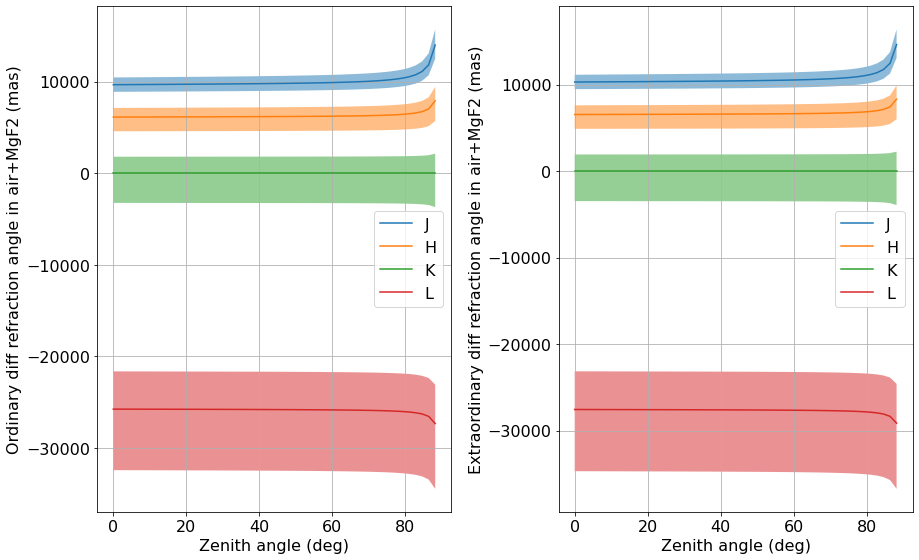

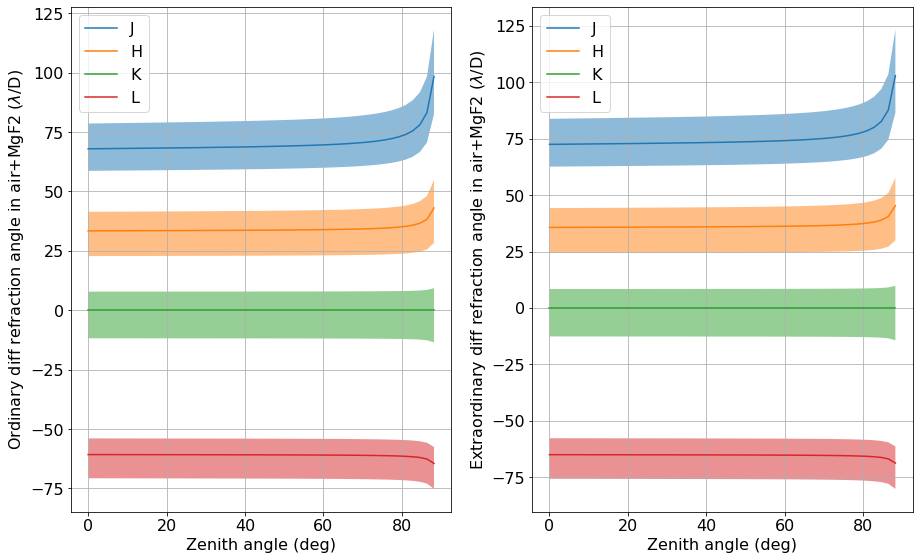

In [10]:
# Same as previously, we define the ordinary and extraordinary refractive indices
# then we calculate the refracted angle inside the MgF2 glass,
window_offset = np.radians(0.5) # The glass is like a prism with a 0.5 degree angle

theta_mgf2_no_J2 = snell_descartes(mgf2_no_J, theta_mgf2_no_J + window_offset, dry_n_J)
theta_mgf2_ne_J2 = snell_descartes(mgf2_ne_J, theta_mgf2_ne_J + window_offset, dry_n_J) 

theta_mgf2_no_H2 = snell_descartes(mgf2_no_H, theta_mgf2_no_H + window_offset, dry_n_H)
theta_mgf2_ne_H2 = snell_descartes(mgf2_ne_H, theta_mgf2_ne_H + window_offset, dry_n_H) 

theta_mgf2_no_K2 = snell_descartes(mgf2_no_K, theta_mgf2_no_K + window_offset, dry_n_K)
theta_mgf2_ne_K2 = snell_descartes(mgf2_ne_K, theta_mgf2_ne_K + window_offset, dry_n_K) 

theta_mgf2_no_L2 = snell_descartes(mgf2_no_L, theta_mgf2_no_L + window_offset, dry_n_L)
theta_mgf2_ne_L2 = snell_descartes(mgf2_ne_L, theta_mgf2_ne_L + window_offset, dry_n_L) 

dtheta_mgf2_no_J2 = theta_mgf2_no_J2 - theta_mgf2_no_K2[operating_wlK_idx]
dtheta_mgf2_no_H2 = theta_mgf2_no_H2 - theta_mgf2_no_K2[operating_wlK_idx]
dtheta_mgf2_no_K2 = theta_mgf2_no_K2 - theta_mgf2_no_K2[operating_wlK_idx]
dtheta_mgf2_no_L2 = theta_mgf2_no_L2 - theta_mgf2_no_K2[operating_wlK_idx]

dtheta_mgf2_ne_J2 = theta_mgf2_ne_J2 - theta_mgf2_ne_K2[operating_wlK_idx]
dtheta_mgf2_ne_H2 = theta_mgf2_ne_H2 - theta_mgf2_ne_K2[operating_wlK_idx]
dtheta_mgf2_ne_K2 = theta_mgf2_ne_K2 - theta_mgf2_ne_K2[operating_wlK_idx]
dtheta_mgf2_ne_L2 = theta_mgf2_ne_L2 - theta_mgf2_ne_K2[operating_wlK_idx]

width = 6.528*2
height = width / 1.618
sz = 16
plt.figure(figsize=(width, height))
plt.rc('xtick', labelsize=sz)
plt.rc('ytick', labelsize=sz)
plt.rc('axes', labelsize=sz)
plt.rc('legend', fontsize=sz)
plt.rc('font', size=sz)
plt.subplot(121)
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_J2[maskJ[1]].T)*3.6e6, label='J')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_H2[maskH[1]].T)*3.6e6, label='H')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_K2[maskK[1]].T)*3.6e6, label='K')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_L2[maskL[1]].T)*3.6e6, label='L')
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_J2[maskJ[0]].T)*3.6e6, np.degrees(dtheta_mgf2_no_J2[maskJ[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_H2[maskH[0]].T)*3.6e6, np.degrees(dtheta_mgf2_no_H2[maskH[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_K2[maskK[0]].T)*3.6e6, np.degrees(dtheta_mgf2_no_K2[maskK[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_no_L2[maskL[0]].T)*3.6e6, np.degrees(dtheta_mgf2_no_L2[maskL[2]].T)*3.6e6, alpha=0.5)
plt.grid()
# plt.ylim(-15*np.degrees(ldL[maskL[1]])*3.6e6, np.degrees(15*ldL[maskL[1]])*3.6e6)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Ordinary diff refraction angle in air+MgF2 (mas)')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_J2[maskJ[1]].T)*3.6e6, label='J')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_H2[maskH[1]].T)*3.6e6, label='H')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_K2[maskK[1]].T)*3.6e6, label='K')
plt.plot(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_L2[maskL[1]].T)*3.6e6, label='L')
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_J2[maskJ[0]].T)*3.6e6, np.degrees(dtheta_mgf2_ne_J2[maskJ[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_H2[maskH[0]].T)*3.6e6, np.degrees(dtheta_mgf2_ne_H2[maskH[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_K2[maskK[0]].T)*3.6e6, np.degrees(dtheta_mgf2_ne_K2[maskK[2]].T)*3.6e6, alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), np.degrees(dtheta_mgf2_ne_L2[maskL[0]].T)*3.6e6, np.degrees(dtheta_mgf2_ne_L2[maskL[2]].T)*3.6e6, alpha=0.5)
plt.grid()
# plt.ylim(-15*np.degrees(ldL[maskL[1]])*3.6e6, np.degrees(15*ldL[maskL[1]])*3.6e6)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Extraordinary diff refraction angle in air+MgF2 (mas)')
plt.legend(loc='best')
plt.tight_layout()

width = 6.528*2
height = width / 1.618
sz = 16
plt.figure(figsize=(width, height))
plt.rc('xtick', labelsize=sz)
plt.rc('ytick', labelsize=sz)
plt.rc('axes', labelsize=sz)
plt.rc('legend', fontsize=sz)
plt.rc('font', size=sz)
plt.subplot(121)
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_no_J2[maskJ[1]].T/ldJ[maskJ[1]], label='J')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_no_H2[maskH[1]].T/ldH[maskH[1]], label='H')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_no_K2[maskK[1]].T/ldK[maskK[1]], label='K')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_no_L2[maskL[1]].T/ldL[maskL[1]], label='L')
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_no_J2[maskJ[0]].T/ldJ[maskJ[0]], dtheta_mgf2_no_J2[maskJ[2]].T/ldJ[maskJ[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_no_H2[maskH[0]].T/ldH[maskH[0]], dtheta_mgf2_no_H2[maskH[2]].T/ldH[maskH[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_no_K2[maskK[0]].T/ldK[maskK[0]], dtheta_mgf2_no_K2[maskK[2]].T/ldK[maskK[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_no_L2[maskL[0]].T/ldL[maskL[0]], dtheta_mgf2_no_L2[maskL[2]].T/ldL[maskL[2]], alpha=0.5)
plt.grid()
# plt.ylim(-10, 10)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Ordinary diff refraction angle in air+MgF2 ($\lambda$/D)')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_ne_J2[maskJ[1]].T/ldJ[maskJ[1]], label='J')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_ne_H2[maskH[1]].T/ldH[maskH[1]], label='H')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_ne_K2[maskK[1]].T/ldK[maskK[1]], label='K')
plt.plot(np.degrees(zenithal_angle), dtheta_mgf2_ne_L2[maskL[1]].T/ldL[maskL[1]], label='L')
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_ne_J2[maskJ[0]].T/ldJ[maskJ[0]], dtheta_mgf2_ne_J2[maskJ[2]].T/ldJ[maskJ[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_ne_H2[maskH[0]].T/ldH[maskH[0]], dtheta_mgf2_ne_H2[maskH[2]].T/ldH[maskH[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_ne_K2[maskK[0]].T/ldK[maskK[0]], dtheta_mgf2_ne_K2[maskK[2]].T/ldK[maskK[2]], alpha=0.5)
plt.fill_between(np.degrees(zenithal_angle), dtheta_mgf2_ne_L2[maskL[0]].T/ldL[maskL[0]], dtheta_mgf2_ne_L2[maskL[2]].T/ldL[maskL[2]], alpha=0.5)
plt.grid()
# plt.ylim(-10, 10)
plt.xlabel('Zenith angle (deg)')
plt.ylabel(r'Extraordinary diff refraction angle in air+MgF2 ($\lambda$/D)')
plt.legend(loc='best')
plt.tight_layout()